In [12]:
import pandas as pd
import glob
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [18]:
def harvest_mod_outputs(path, file_pattern, output_filename=None):
    """
    Processes files in a directory matching a pattern, extracts parameters from filenames,
    and creates subplots comparing linear vs neural correlations by QTL parameter.

    Args:
        path: String path to the directory containing files
        file_pattern: String pattern for glob to match files (e.g., 'qhaplo_*qtl_*marker_*n_rep*_*.csv')
        output_filename: Optional filename for saving the plot (default: 'correlation_comparison.png')

    Returns:
        DataFrame: Combined dataframe of all processed files
        Figure: Matplotlib figure object for further customization if needed
    """
    # Get all files that match the pattern
    csv_files = glob.glob(os.path.join(path, file_pattern))

    if not csv_files:
        print(f"No files found matching pattern '{file_pattern}' in '{path}'")
        return None, None

    # Create an empty list to store individual dataframes
    dfs = []

    # Process each file
    for file in csv_files:
        # Extract the filename from the path
        filename = os.path.basename(file)

        # Extract parameters using regex
        qtl_match = re.search(r'(\d+)qtl', filename)
        n_match = re.search(r'(\d+)n', filename)
        rep_match = re.search(r'rep(\d+)', filename)
        trait_match = re.search(r'(\d+)trait', filename)
        pleio_match = re.search(r'(\d+)pleio', filename)

        if qtl_match and n_match and rep_match:
            qtl_value = int(qtl_match.group(1))
            n_value = int(n_match.group(1))
            rep_value = int(rep_match.group(1))
            trait_value = int(trait_match.group(1))
            pleio_value = int(pleio_match.group(1))


                # Read the CSV file
            df = pd.read_csv(file)

            # Add columns for the parameters
            df['qtl_param'] = qtl_value
            df['n_param'] = n_value
            df['rep'] = rep_value
            df['n_trait'] = trait_value
            df['pleio'] = pleio_value


            # Add the dataframe to our list
            dfs.append(df)
        else:
            print(f"Couldn't extract parameters from {filename}")

    # Combine all dataframes into one
    if dfs:
        outdf = pd.concat(dfs, ignore_index=True)

        # Display the first few rows of the combined dataframe
        print(outdf.head())

    else:
        print("No matching files found or parameters couldn't be extracted")
    return outdf

In [19]:
linear_df = harvest_mod_outputs('./gplinear', 'qhaplo_*qtl_*n_*pleio_*trait_rep*_phenotype_correlations_untuned.csv')
neural_df = harvest_mod_outputs('./gpnet', 'qhaplo_*qtl_*n_*pleio_*trait_rep*_phenotype_correlations_untuned.csv')

   trait_number  pearson_correlation  p_value  true_mean  pred_mean  true_std  \
0             1             0.961883      0.0  -0.010221   0.048607  0.997869   
1             2             0.495569      0.0   0.004498  -0.036001  1.038936   
2             3             0.453880      0.0  -0.046243  -0.040024  0.999047   
3             4             0.457719      0.0  -0.005747  -0.028157  0.969673   
4             5             0.462718      0.0   0.020526  -0.005327  1.015415   

   pred_std trait_architecture  qtl_param  n_param  rep  n_trait  pleio  
0  0.322912                1-5       1000    10000    2       10     25  
1  0.174232                1-5       1000    10000    2       10     25  
2  0.169844                1-5       1000    10000    2       10     25  
3  0.179712                1-5       1000    10000    2       10     25  
4  0.177700                1-5       1000    10000    2       10     25  
   trait_number  pearson_correlation  p_value  true_mean  pred_mean  

In [20]:

def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait', 'rep']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait', 'rep']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number', 'pleio', 'n_trait', 'rep'])

    return common_params

# Get common parameter combinations
common_params = get_parameter_combinations(linear_df, neural_df)

In [38]:
comparison_data = []

for _, row in common_params.iterrows():
    qtl = row['qtl_param']
    n = row['n_param']
    trait = row['trait_number']
    pleio = row['pleio']
    n_trait = row['n_trait']
    rep = row['rep']

    linear_row = linear_df[(linear_df['qtl_param'] == qtl) &
                           (linear_df['n_param'] == n) &
                           (linear_df['trait_number'] == trait) &
                           (linear_df['pleio'] == pleio) &
                           (linear_df['n_trait'] == n_trait)&
                           (linear_df['rep'] == rep)]

    neural_row = neural_df[(neural_df['qtl_param'] == qtl) &
                           (neural_df['n_param'] == n) &
                           (neural_df['trait_number'] == trait) &
                           (neural_df['pleio'] == pleio) &
                           (neural_df['n_trait'] == n_trait) &
                           (neural_df['rep'] == rep)]

    if not linear_row.empty and not neural_row.empty:
        comparison_data.append({
            'qtl_param': qtl,
            'n_param': n,
            'trait_number': trait,
            'rep': rep,
            'pleio': pleio,
            'n_trait': n_trait,
            'linear_correlation': linear_row['pearson_correlation'].values[0],
            'neural_correlation': neural_row['pearson_correlation'].values[0],
            'difference': (neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0])/linear_row['pearson_correlation'].values[0]
        })

df = pd.DataFrame(comparison_data)

In [39]:
df = df[(df['trait_number'] != 1) & (df['trait_number'] != 2)]
df.head(n=15)

,qtl_param,n_param,trait_number,rep,pleio,n_trait,linear_correlation,neural_correlation,difference
2,1000,10000,3,2,25,10,0.453880,0.471452,0.038714
3,1000,10000,4,2,25,10,0.457719,0.477932,0.044160
4,1000,10000,5,2,25,10,0.462718,0.479763,0.036836
5,1000,10000,6,2,25,10,0.478353,0.495836,0.036548
6,1000,10000,7,2,25,10,0.505944,0.508732,0.005512
7,1000,10000,8,2,25,10,0.513490,0.522394,0.017339
8,1000,10000,9,2,25,10,0.448252,0.468021,0.044102
9,1000,10000,10,2,25,10,0.439936,0.440468,0.001210
10,1000,10000,11,2,25,10,0.493074,0.519255,0.053098
11,1000,10000,12,2,25,10,0.500383,0.509427,0.018074


In [40]:
# Group by all columns except the numerical ones we want to average
groupby_columns = ['qtl_param', 'n_param', 'pleio', 'n_trait', 'rep']
agg_columns = ['linear_correlation', 'neural_correlation', 'difference']

# Perform the groupby and aggregation
summary_df = df.groupby(groupby_columns)[agg_columns].mean().reset_index()

# Rename the columns to indicate they are averages
summary_df = summary_df.rename(columns={
    'linear_correlation': 'avg_linear_correlation',
    'neural_correlation': 'avg_neural_correlation',
    'difference': 'avg_difference'
})

# Add a count column
count_df = df.groupby(groupby_columns).size().reset_index(name='count')
summary_df = pd.merge(summary_df, count_df, on=groupby_columns)

In [41]:
summary_df

,qtl_param,n_param,pleio,n_trait,rep,avg_linear_correlation,avg_neural_correlation,avg_difference,count
0,100,10000,0,10,1,0.578907,0.919258,0.599926,10
1,100,10000,0,10,2,0.553521,0.918671,0.674131,10
2,100,10000,0,10,3,0.587293,0.922496,0.578967,10
3,100,10000,0,10,4,0.552204,0.914487,0.666541,10
4,100,10000,0,10,5,0.572264,0.921999,0.635458,10
...,...,...,...,...,...,...,...,...,...
245,1000,10000,95,100,1,0.418629,0.434625,0.038591,100
246,1000,10000,95,100,2,0.482124,0.507015,0.051946,100
247,1000,10000,95,100,3,0.535355,0.551955,0.031110,100
248,1000,10000,95,100,4,0.432618,0.461974,0.068108,100


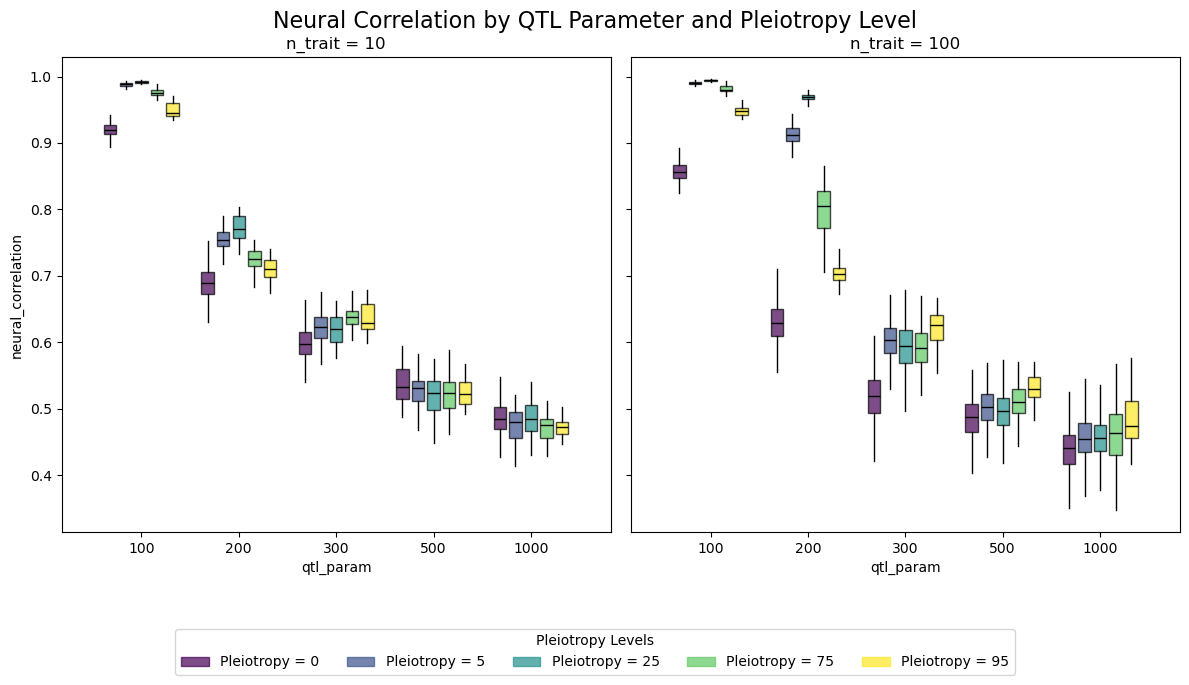

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your already properly formatted DataFrame

# Get unique values
qtl_param_values = sorted(df['qtl_param'].unique())
pleio_values = sorted(df['pleio'].unique())
unique_n_traits = sorted(df['n_trait'].unique())

# Create a figure with subplots in one row (one subplot per n_trait)
fig, axes = plt.subplots(1, len(unique_n_traits), figsize=(6*len(unique_n_traits), 6),
                         sharey=True)

# Create color map for pleiotropy levels
pleio_colors = plt.cm.viridis(np.linspace(0, 1, len(pleio_values)))
pleio_color_map = dict(zip(pleio_values, pleio_colors))

# Create each subplot (one per n_trait)
for i, n_trait in enumerate(unique_n_traits):
    # Get the correct axis for this subplot
    if len(unique_n_traits) == 1:
        ax = axes
    else:
        ax = axes[i]

    # Filter data for this n_trait
    n_trait_data = df[df['n_trait'] == n_trait]

    # Remove control traits
    n_trait_data = n_trait_data[~n_trait_data['trait_number'].isin([1, 2])]

    # For each qtl_param value
    for j, qtl_param in enumerate(qtl_param_values):
        # Filter data for this qtl_param
        qtl_data = n_trait_data[n_trait_data['qtl_param'] == qtl_param]

        if not qtl_data.empty:
            # Set the x-position for this group of boxplots
            x_pos = j + 1  # Base position (1, 2, 3, etc.)

            # Prepare data for side-by-side boxplots
            boxplot_data = []
            positions = []
            colors = []

            # Group by pleiotropy level
            for k, pleio_val in enumerate(pleio_values):
                # Filter data for this pleiotropy level
                pleio_data = qtl_data[qtl_data['pleio'] == pleio_val]

                if not pleio_data.empty:
                    values = pleio_data['neural_correlation'].values
                    if len(values) > 0:
                        boxplot_data.append(values)

                        # Calculate offset for side-by-side positioning
                        width = 0.8 / len(pleio_values)
                        offset = (k - (len(pleio_values)-1)/2) * width
                        positions.append(x_pos + offset)

                        colors.append(pleio_color_map[pleio_val])

            # Create boxplots for this qtl_param
            if boxplot_data:
                bplot = ax.boxplot(boxplot_data, positions=positions,
                                  patch_artist=True, widths=0.8/len(pleio_values)*0.8,
                                  showfliers=False, showcaps=False,
                                  medianprops={'color': 'black'},
                                  boxprops={'color': 'black'})

                # Color boxplots based on pleiotropy level
                for patch, color in zip(bplot['boxes'], colors):
                    patch.set(facecolor=color, alpha=0.7)

    # Set titles and labels
    ax.set_title(f'n_trait = {n_trait}')
    ax.set_xlabel('qtl_param')
    if i == 0:  # Only add y-label to the first subplot
        ax.set_ylabel('neural_correlation')

    # Set x-tick positions and labels
    ax.set_xticks(range(1, len(qtl_param_values) + 1))
    ax.set_xticklabels(qtl_param_values)


# Add a legend for pleiotropy levels
handles = []
labels = []
for pleio_val in pleio_values:
    patch = plt.Rectangle((0, 0), 1, 1, color=pleio_color_map[pleio_val], alpha=0.7)
    handles.append(patch)
    labels.append(f'Pleiotropy = {pleio_val}')

# Add the legend
fig.legend(handles, labels, title='Pleiotropy Levels',
           loc='upper center', bbox_to_anchor=(0.5, 0),
           ncol=min(5, len(pleio_values)))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the legend at the bottom

# Add overall title
plt.suptitle('Neural Correlation by QTL Parameter and Pleiotropy Level',
             fontsize=16, y=1.02)

# Show the plot
plt.show()

# If you want to save the figure
# plt.savefig('correlation_boxplots_by_n_trait.png', dpi=300, bbox_inches='tight')

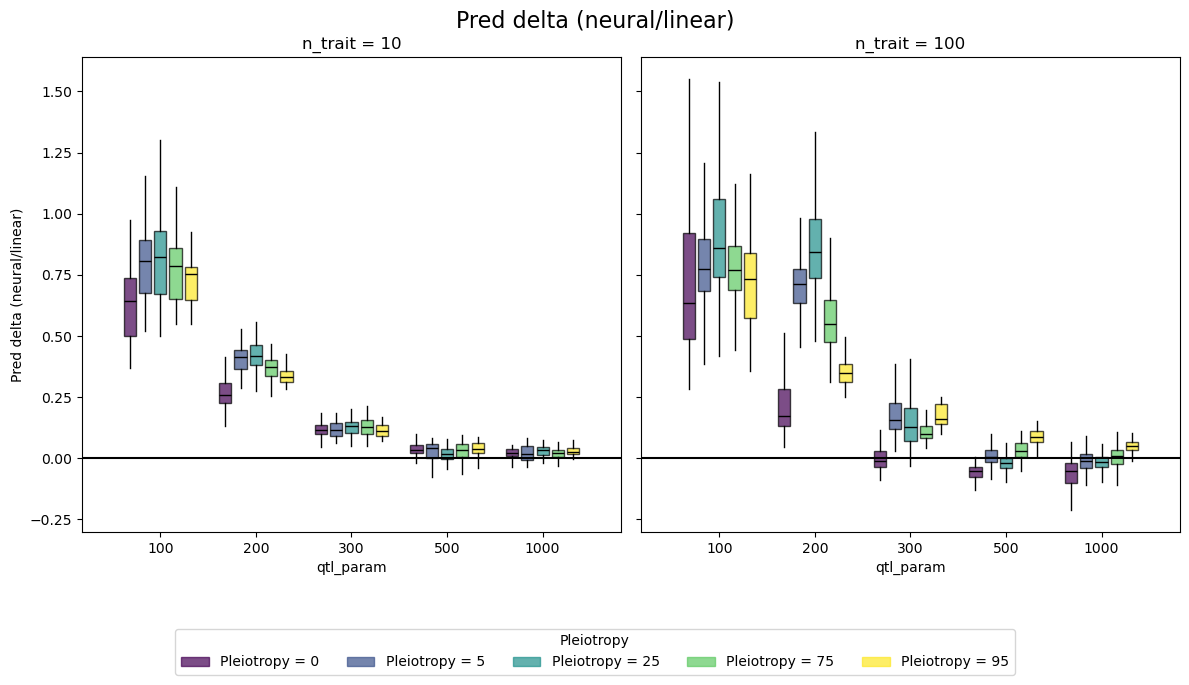

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your already properly formatted DataFrame

# Get unique values
qtl_param_values = sorted(df['qtl_param'].unique())
pleio_values = sorted(df['pleio'].unique())
unique_n_traits = sorted(df['n_trait'].unique())

# Create a figure with subplots in one row (one subplot per n_trait)
fig, axes = plt.subplots(1, len(unique_n_traits), figsize=(6*len(unique_n_traits), 6),
                         sharey=True)

# Create color map for pleiotropy levels
pleio_colors = plt.cm.viridis(np.linspace(0, 1, len(pleio_values)))
pleio_color_map = dict(zip(pleio_values, pleio_colors))

# Create each subplot (one per n_trait)
for i, n_trait in enumerate(unique_n_traits):
    # Get the correct axis for this subplot
    if len(unique_n_traits) == 1:
        ax = axes
    else:
        ax = axes[i]

    # Filter data for this n_trait
    n_trait_data = df[df['n_trait'] == n_trait]

    # Remove control traits
    n_trait_data = n_trait_data[~n_trait_data['trait_number'].isin([1, 2])]

    # For each qtl_param value
    for j, qtl_param in enumerate(qtl_param_values):
        # Filter data for this qtl_param
        qtl_data = n_trait_data[n_trait_data['qtl_param'] == qtl_param]

        if not qtl_data.empty:
            # Set the x-position for this group of boxplots
            x_pos = j + 1  # Base position (1, 2, 3, etc.)

            # Prepare data for side-by-side boxplots
            boxplot_data = []
            positions = []
            colors = []

            # Group by pleiotropy level
            for k, pleio_val in enumerate(pleio_values):
                # Filter data for this pleiotropy level
                pleio_data = qtl_data[qtl_data['pleio'] == pleio_val]

                if not pleio_data.empty:
                    values = pleio_data['difference'].values
                    if len(values) > 0:
                        boxplot_data.append(values)

                        # Calculate offset for side-by-side positioning
                        width = 0.8 / len(pleio_values)
                        offset = (k - (len(pleio_values)-1)/2) * width
                        positions.append(x_pos + offset)

                        colors.append(pleio_color_map[pleio_val])

            # Create boxplots for this qtl_param
            if boxplot_data:
                bplot = ax.boxplot(boxplot_data, positions=positions,
                                  patch_artist=True, widths=0.8/len(pleio_values)*0.8,
                                  showfliers=False, showcaps=False,
                                  medianprops={'color': 'black'},
                                  boxprops={'color': 'black'})

                # Color boxplots based on pleiotropy level
                for patch, color in zip(bplot['boxes'], colors):
                    patch.set(facecolor=color, alpha=0.7)

    # Set titles and labels
    ax.set_title(f'n_trait = {n_trait}')
    ax.set_xlabel('qtl_param')
    if i == 0:  # Only add y-label to the first subplot
        ax.set_ylabel('Pred delta (neural/linear)')

    # Set x-tick positions and labels
    ax.set_xticks(range(1, len(qtl_param_values) + 1))
    ax.set_xticklabels(qtl_param_values)
    ax.axhline(y=0, color='black')


# Add a legend for pleiotropy levels
handles = []
labels = []
for pleio_val in pleio_values:
    patch = plt.Rectangle((0, 0), 1, 1, color=pleio_color_map[pleio_val], alpha=0.7)
    handles.append(patch)
    labels.append(f'Pleiotropy = {pleio_val}')

# Add the legend
fig.legend(handles, labels, title='Pleiotropy',
           loc='upper center', bbox_to_anchor=(0.5, 0),
           ncol=min(5, len(pleio_values)))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make space for the legend at the bottom



# Add overall title
plt.suptitle('Pred delta (neural/linear)',
             fontsize=16, y=1.02)

# Show the plot
plt.show()